# Gym environment for multi-layer thin film optimization
Gym environment to implement the generation of multi-layer thin films as Markov decision processes
In this notebook the key features of gym-mltf are explained and demonstrated.
But notably this framework is model-agnostic and can be used in conjuction with any optimizer aside from RL algorithms to design multi-layer thin films.

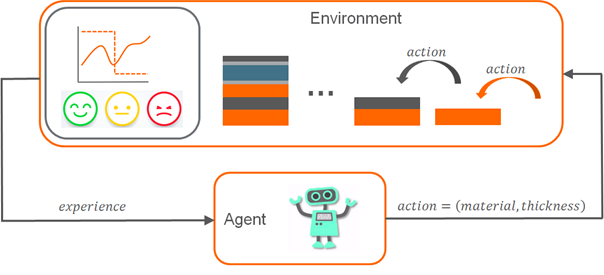
Figure: Principal idea of an OpenAI gym environment. The agent takes an action that specifies the material and thickness of the layer to stack next. The environment implements the multi-layer thin film generation as consecutive conduction of actions and assigns a reward to a proposed multi-layer thin film based on how close the actual (solid orange line) fulfils a desired (dashed orange line) characteristic. The made experience is used to adapt the taken actions made in order to increase the reward and thus generate more and more sophisticated multi-layer thin films.




Let's start!

In [1]:
# The first step is - of course - to import the package and numpy
import gym_multilayerthinfilm as gym_mltf
import numpy as np

Now, we can specify some basic conditions of our problem. 
For example how many layer our multi-layer thin film should not exceed? 
Which angular range (°, degree) should be covered?
Which spectrum (nanometer, nm) of incoming light is of relevance?
The answer to these questions may differ from application to application...

In addtion we can specify the meshing by providing ticks that is the number of supporting points of the angles and spectrum, repsectively. Note that - altough transfer-matrix computation was parallelized - more supporting points lead to higher computational costs.

In [2]:
maximum_number_of_layers = 12
ticks_angle = 180
angle_min = 0
angle_max = 90
ticks_spectrum = 900
wl_min = 300 * (10**(-9))
wl_max = 1200 * (10**(-9))

In the next step, we specify three materials that we can choose from during stacking the multi-layer thin film. Namely, Nb2O5, SiO2 and Au (gold) are available.
For each of these materials a txt-file is available via measurements that holds the respective dispersive complex refractive indicies. Have a look:
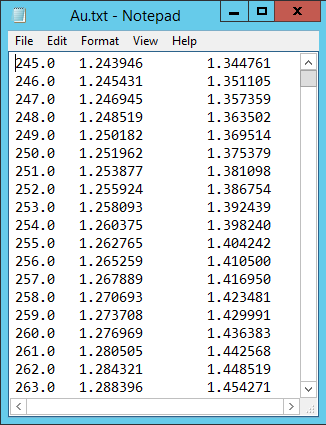
Here, the first column denotes the wavelength of the incoming light, the second column holds the real-part of the complex refractive index and the third column holds the imaginary-part of the complex refractive index.

We can use the built-in method get_N to read in the aformentioned txt-files. get_N transformes the measurement data in the txt-files to an approbiate range given the above spectral specifications regarding supporting points and borders. However, make sure that your measured data in the txt-files does NOT exceed the previously specified spectrum.

In general, it does not matter how to obtain the np.array N. Notably, N should be of dimension M x S where M is the number of available materials and S is the number of supporting points of the spectrum. N features complex or real-valued entries and holds the (dispersive) refractive indicies of the available materials. You can specify, whether you want to read in complex refractive indicies (complex_n=True) or only their real part (complex_n=False).

In [3]:
pathAu = 'default_materials\\Au.txt'
pathNb2O5 = 'default_materials\\Nb2O5.txt'
pathSiO2 = 'default_materials\\SiO2.txt'
material_path_list = [pathAu, pathNb2O5, pathSiO2]

N = gym_mltf.get_N(material_path_list, wl_min * 10**9, wl_max * 10**9, points=ticks_spectrum, complex_n=True)

In the next step, we specifiy what a perfect multi-layer thin film should look like. Therefore, we can specify a target reflectivity for each angle and wavelength. For a first shot, we aim to achieve highest reflectivity everywhere.
After that done, we create np.arrays which hold the supporting points of the angles and wl and create. 

Finally, we create a dictionary.

In [4]:
target_array = np.ones((ticks_angle, ticks_spectrum))
angle = np.linspace(angle_min, angle_max, ticks_angle)
wl = np.linspace(wl_min, wl_max, ticks_spectrum)
target = {'direction': angle, 'spectrum': wl, 'target': target_array}

Note that we could also optimize for one wavelenght or angle by just setting e.g. angle = np.array([0.0]) (forward direction) or wl = np.array([700 * (10**(-9)]) (IR-laser).

But anyway, we can now feed all of our specifcation to the gym_mltf class to create an environment. In addtion, we changed the default values for minimal and maximal layer thicknesses.
For fun, we sample a random action from the action space and print it.

In [15]:
env = gym_mltf.MultiLayerThinFilm(N, maximum_number_of_layers, target, max_thickness=100e-9, min_thickness=0)
print('This is an action:')
print(env.action_space.sample())

--- substrate is set to vacuum of infinite thickness ---
--- ambient is set to vacuum of infinite thickness ---
This is an action:
(1, array([0.22719245], dtype=float32))


But uuuups? - We did forget to specify a substrate and an ambient. Fortunately, this error did not only happend to us. If no ambient or substrate is provided, it is set to air/vacuum with infinite thickness.
Just in case you want to specify an ambient or substrate, you can do it via
env = gym_mltf.MultiLayerThinFilm(N, maximum_number_of_layers, target, substrate=substrate_dict)
Substrate holds the (dispersive, complex) refractive indicies of the substrate materials in the rows of substrate['n'] which is of shape np.array of shape [Sub x S] . Sub is the number of materials that form the substrate. substrate['d'] is of shape Sub and holds the corresponding thicknesses of each layer. For ambient the same formalism holds!

Moreover, we see our printed action! In this case, we choose to stack material action[0] of thicknness 
(max_thickness - min_thickness) * action[1] + min_thickness.

Let's reset the environment, take some random actions and render the environment afterwards:

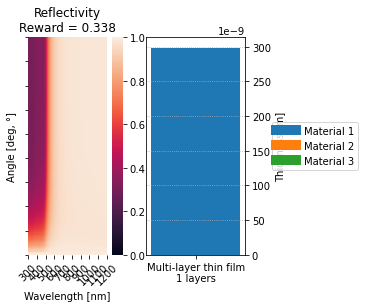

In [13]:
env.reset()
env.step(env.action_space.sample())
env.step(env.action_space.sample())
env.step(env.action_space.sample())
env.step(env.action_space.sample())
_ = env.render()

How many layers did you observe? - It should not be more than 12 of course. But it may be less (start restart some times). This can have two reasons: 1. The random sampling decides to stack the same material at least twice. This leads to one "very thick" layer or 2. The algorithm decided to terminate stacking, e.g. action[0] == 0 in some step. Let's do another step (and hope we do not choose the terminal action :)). We take this chance to investigate the returns of the step method as well.

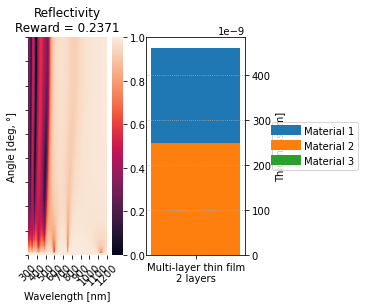

In [12]:
status_list, reward, _, _ = env.step(env.action_space.sample())
_ = env.render()

Hopefully, you saw above that an additional layer was stacked (and no terminal action was taken) otherwise simply restart the previous code line. The render method returns the figure and axes in a list which allows you to adapt them further.

To end this tutorial let's investigate the returns of the step-method. These are the information that your reinforcement learning agent may sees and what his/her policy may be based on!

The first return, status_list, holds the transfer-matrix result as an np.array that is above illustrated as an heatmap. In addtion, this list holds the matrix of refractive indicies which is also an np.array and a row-wise permutation of N with replacement. It does not include the cladding. Just like the thickness array. It determines the thickness of each placed layer.
You can combine, processes or do some other magic with this return list to compute a status that is handed to your RL algorithm.
The second return is the reward that is assigned to the multi-layer thin films reflectivity behavior and reflects how close this behavior fullfils the target.

As a little excerise: Stack a multi-layer thin film with 3 layers of SiO2, Nb2O5 and SiO2 with arbitary thicknesses. the substrate should be air of infinite thickness. The ambient should be gold of 200nm thickness. Try to maximize the reflectivity for each angle between 0° and 45°. The system is illuminated by a UV-laser at 200nm. 




Solution:


In [4]:
maximum_number_of_layers = 12
ticks_angle = 90
angle_min = 0
angle_max = 45
ticks_spectrum = 1
wl_min = 550 * (10**(-9))
wl_max = 550 * (10**(-9))

pathAu = 'default_materials\\Au.txt'
pathNb2O5 = 'default_materials\\Nb2O5.txt'
pathSiO2 = 'default_materials\\SiO2.txt'
material_path_list = [pathAu, pathNb2O5, pathSiO2]

N = gym_mltf.get_N(material_path_list, wl_min * 10**9, wl_max * 10**9, points=ticks_spectrum, complex_n=True)

target_array = np.ones((ticks_angle, ticks_spectrum))
angle = np.linspace(angle_min, angle_max, ticks_angle)
wl = np.linspace(wl_min, wl_max, ticks_spectrum)
target = {'direction': angle, 'spectrum': wl, 'target': target_array}
ambient_dict = {'n': N[0, :].reshape(1, -1), 'd': np.array([200e-9]).reshape(1)}
env = gym_mltf.MultiLayerThinFilm(N, maximum_number_of_layers, target, ambient=ambient_dict)
action_layer1_SiO2 = tuple((int(3), 0.25))
action_layer2_Nb2O5 = tuple((int(2), 0.75))
action_layer3_SiO2 = tuple((int(3), 0.25))
env.step(action_layer1_SiO2)
env.step(action_layer2_Nb2O5)
env.step(action_layer3_SiO2)
_ = env.render()

--- substrate is set to vacuum of infinite thickness ---


AssertionError: n_ambient must feature real-valued refractive indicies in last layer for computational/physical reasons (TMM)..

Ah, again an error! Well, for physical reasons, the first layer of the substrate and the last layer of the ambient must only feature real-valued refractive indicies. We adapt this by application of np.real() onto ambient_dict['n']. Note that the substrate remains undefined and thus is set to air.

Now, the code should be fine:

--- substrate is set to vacuum of infinite thickness ---


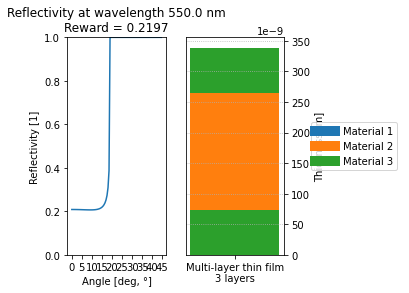

In [6]:
ambient_dict = {'n': np.real(N[0, :]).reshape(1, -1), 'd': np.array([200e-9]).reshape(1)}
env = gym_mltf.MultiLayerThinFilm(N, maximum_number_of_layers, target, ambient=ambient_dict)
action_layer1_SiO2 = tuple((int(3), 0.25))
action_layer2_Nb2O5 = tuple((int(2), 0.75))
action_layer3_SiO2 = tuple((int(3), 0.25))
env.step(action_layer1_SiO2)
env.step(action_layer2_Nb2O5)
env.step(action_layer3_SiO2)
_ = env.render()